In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
from cell2location.utils import select_slide
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
results_folder = './results/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Load datasets

读入scRNA-seq参考数据

In [3]:
# Read data
adata_ref = sc.read("data/RCC_upload_final_raw_counts.h5ad")

作者原文做了两层注释：
- major cell type: `adata_ref.obs['broad_type']`
- minor cell type: `adata_ref.obs['annotation']`

In [4]:
adata_ref.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,patient,percent.mt,summaryDescription,annotation,region,broad_type
5739STDY7958790_AACTCAGTCCTCAACC-1,5739STDY7958790,4916.0,301,PD43948,3.641172,Blood,Plasma-IgG,b,Plasma
5739STDY7958790_AAGTCTGTCGGATGGA-1,5739STDY7958790,2708.0,903,PD43948,7.053176,Blood,Switched-memory_B,b,B-cell
5739STDY7958790_ACACCCTGTGTGAAAT-1,5739STDY7958790,4575.0,672,PD43948,2.710383,Blood,Plasma-IgA,b,Plasma
5739STDY7958790_ACATGGTTCAGTTTGG-1,5739STDY7958790,2931.0,1361,PD43948,8.597748,Blood,Naïve_B.2,b,B-cell
5739STDY7958790_ACCGTAAGTCTTCTCG-1,5739STDY7958790,5965.0,266,PD43948,0.670578,Blood,Plasma-IgA,b,Plasma


In [5]:
adata_ref.shape

(270855, 19736)

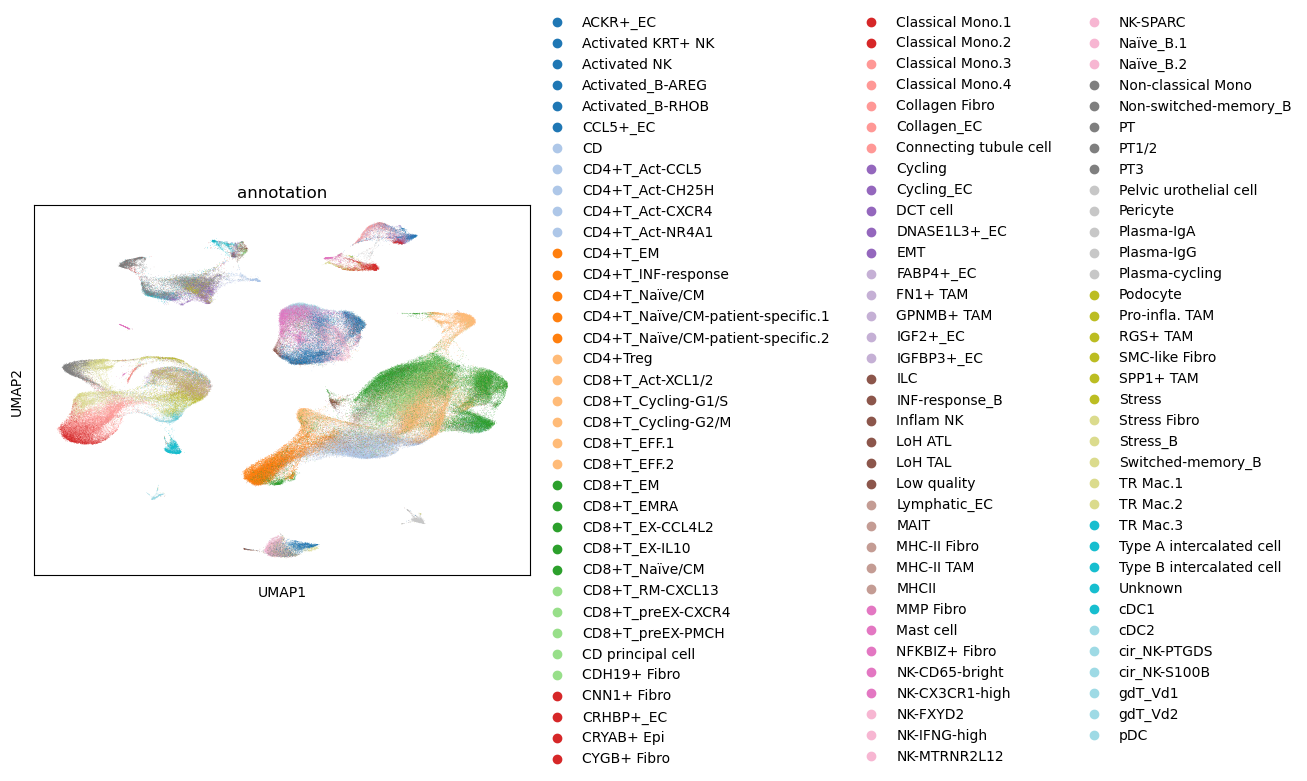

In [6]:
sc.pl.umap(adata_ref, color="annotation")

Two major steps were in analysis using cell2location: 
1. We applied a negative binomial regression model implemented in cell2location and estimated the reference signature of cell types we annotated based on scRNA-seq data. In this step, we used an unnormalized mRNA count matrix as input and filtered it to 13,042 genes and 261,202 cells (cells that were annotated as unknown, low-quality and patient specific were removed from this analysis). Donor IDs were regarded as the batch category and the following parameters were used to train the model: ‘max_epochs’ = 120, ‘batch_size’ = 2500, ‘train_size’ = 1 and ‘Ir’ = 0.002.

按照作者Method部分的描述，我们首先对单细胞数据中的**unknown**,**low quanlity**以及**patient-specific**细胞类型进行过滤

In [7]:
removed_labels = ['Unknown', 'Low quality','CD4+T_Naïve/CM-patient-specific.1', 'CD4+T_Naïve/CM-patient-specific.2']
adata_ref.obs['annotation'].isin(removed_labels).value_counts()

False    261202
True       9653
Name: annotation, dtype: int64

In [8]:
adata_ref = adata_ref[~adata_ref.obs['annotation'].isin(removed_labels)]
adata_ref

View of AnnData object with n_obs × n_vars = 261202 × 19736
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type'
    var: 'name'
    uns: 'annotation_colors', 'broad_type_colors', 'region_colors', 'summaryDescription_colors'
    obsm: 'X_pca', 'X_umap'

过滤基因<br>
作者最终保留了13,042个基因，但由于他没有告诉我们过滤标准，这里我们采用官方文档采用的过滤参数。

/home/conda/envs/scrna/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/home/conda/envs/scrna/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


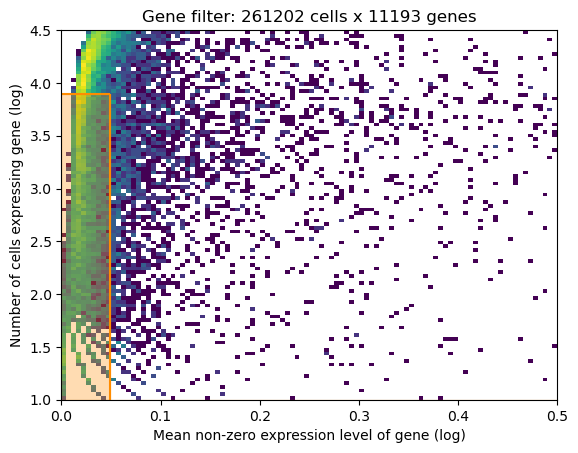

In [9]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

## step1 Training reference models

`patient` were regarded as the batch category

In [10]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='patient',
                        # cell type, covariate used for constructing signatures
                        labels_key='annotation'
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method']
                       )

/home/conda/envs/scrna/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [11]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'patient',
│   'labels_key': 'annotation',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│          n_vars          │ 11193  │
│         n_cells          │ 261202 │
│         n_batch          │   12   │
│         n_labels         │  103   │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │  PD43824   │          0          │
│                      │  PD43948   │          1          │
│                      │  PD44714   │          2          │
│                      │  PD44966   │          3          │
│                      │  PD44967   │          4          │
│                      │  PD45814   │          5          │
│                      │  PD45815   │          6          │
│                      │  PD45816   │          7          │
│                      │  PD47171   │          8          │
│                      │  PD47172   │          9          │
│                      │  PD47465   │         10          │
│                      │  PD47512   │         11          │
└──────────────────────┴────────────┴─────────────────────┘

                           labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annotation'] │         ACKR+_EC         │          0          │
│                         │    Activated KRT+ NK     │          1          │
│                         │       Activated NK       │          2          │
│                         │     Activated_B-AREG     │          3          │
│                         │     Activated_B-RHOB     │          4          │
│                         │         CCL5+_EC         │          5          │
│                         │            CD            │          6          │
│                         │      CD4+T_Act-CCL5      │          7          │
│                         │     CD4+T_Act-CH25H      │          8          │
│                         │     CD4+T_Act-CXCR4      │          9          │
│                         │     CD4+T_Act-NR4A1      │         10          │
│                         │         CD4+T_EM         │         11          │
│                         │    CD4+T_INF-response    │         12          │
│                         │      CD4+T_Naïve/CM      │         13          │
│                         │         CD4+Treg         │         14          │
│                         │     CD8+T_Act-XCL1/2     │         15          │
│                         │    CD8+T_Cycling-G1/S    │         16          │
│                         │    CD8+T_Cycling-G2/M    │         17          │
│                         │       CD8+T_EFF.1        │         18          │
│                         │       CD8+T_EFF.2        │         19          │
│                         │         CD8+T_EM         │         20          │
│                         │        CD8+T_EMRA        │         21          │
│                         │     CD8+T_EX-CCL4L2      │         22          │
│                         │      CD8+T_EX-IL10       │         23          │
│                         │      CD8+T_Naïve/CM      │         24          │
│                         │     CD8+T_RM-CXCL13      │         25          │
│                         │    CD8+T_preEX-CXCR4     │         26          │
│                         │     CD8+T_preEX-PMCH     │         27          │
│                         │    CD principal cell     │         28          │
│                         │       CDH19+ Fibro       │         29          │
│                         │       CNN1+ Fibro        │         30          │
│                         │        CRHBP+_EC         │         31          │
│                         │        CRYAB+ Epi        │         32          │
│                         │       CYGB+ Fibro        │         33          │
│                         │     Classical Mono.1     │         34          │
│                         │     Classical Mono.2     │         35          │
│                         │     Classical Mono.3     │         36          │
│                         │     Classical Mono.4     │         37          │
│                         │      Collagen Fibro      │         38          │
│                         │       Collagen_EC        │         39          │
│                         │  Connecting tubule cell  │         40          │
│                         │         Cycling          │         41          │
│                         │        Cycling_EC        │         42          │
│                         │         DCT cell         │         43          │
│                         │       DNASE1L3+_EC       │         44          │
│                         │           EMT            │         45          │
│                         │        FABP4+_EC         │         46          │
│                         │         FN1+ TAM         │         47        

the following parameters were used to train the model: 
- ‘max_epochs’ = 120, 
- ‘batch_size’ = 2500, (default)
- ‘train_size’ = 1 (default)
- ‘Ir’ = 0.002 (default)

保证服务器有足够多空闲的核，默认使用一半线程

In [16]:
import torch
if torch.cuda.is_available():
    mod.train(max_epochs=120, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

In [13]:
mod.train(max_epochs=120, batch_size=2500, train_size=1, lr=0.002, use_gpu=False) # 使用CPU计算

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 120/120: 100%|██████████████| 120/120 [5:16:48<00:00, 153.59s/it, v_num=1, elbo_train=9.44e+8]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 120/120: 100%|██████████████| 120/120 [5:16:48<00:00, 158.41s/it, v_num=1, elbo_train=9.44e+8]


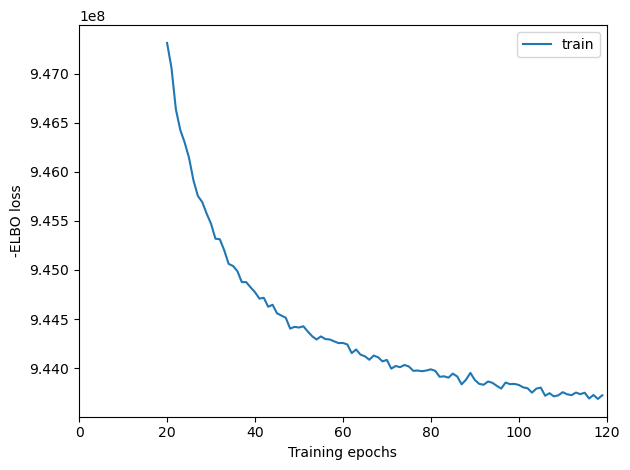

In [14]:
mod.plot_history(20)

In [17]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

Sampling global variables, sample: 100%|██████████████████████████| 999/999 [01:02<00:00, 15.90it/s]


In [18]:
# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'./results//reference_signatures/sc.h5ad'

这里两个散点图(诊断图)具有正相关的趋势说明模型能够用来解释数据

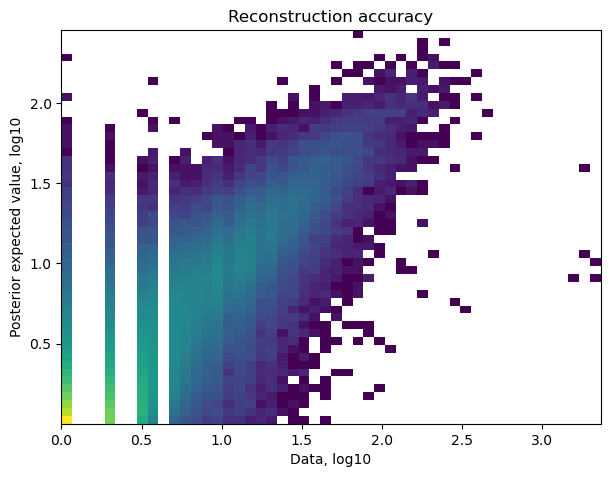

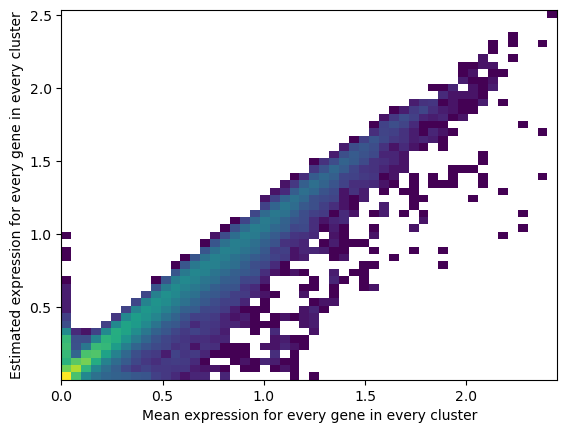

In [19]:
mod.plot_QC()

In [20]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,ACKR+_EC,Activated KRT+ NK,Activated NK,Activated_B-AREG,Activated_B-RHOB
FO538757.2,0.095478,0.090512,0.110985,0.055967,0.075919
NOC2L,0.138662,0.127062,0.117580,0.117451,0.114746
PERM1,0.002008,0.000344,0.000227,0.001351,0.002163
HES4,0.011849,0.006743,0.051286,0.004431,0.004672
ISG15,0.412864,0.386006,0.502053,0.174437,0.136781


In [21]:
# save inf_aver
inf_aver.to_csv(f"{ref_run_name}/inf_aver.csv")